#  Data Understanding & Exploration

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('/kaggle/input/top-100-cryptocurrency-2020-2025/top_100_cryptos_with_correct_network.csv')

In [2]:
print("Dataset shape:", df.shape)
print("Column names:", df.columns.tolist())

Dataset shape: (211679, 7)
Column names: ['symbol', 'date', 'open', 'high', 'low', 'close', 'network']


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   symbol   211679 non-null  object 
 1   date     211679 non-null  object 
 2   open     211679 non-null  float64
 3   high     211679 non-null  float64
 4   low      211679 non-null  float64
 5   close    211679 non-null  float64
 6   network  211679 non-null  object 
dtypes: float64(4), object(3)
memory usage: 11.3+ MB


In [4]:
df.head()

,symbol,date,open,high,low,close,network
0,BTCUSDT,2018-08-01,7735.67,7750.00,7430.00,7604.58,Bitcoin
1,BTCUSDT,2018-08-02,7600.08,7709.46,7455.72,7525.71,Bitcoin
2,BTCUSDT,2018-08-03,7525.71,7540.00,7282.44,7418.78,Bitcoin
3,BTCUSDT,2018-08-04,7412.27,7494.81,6926.00,7009.84,Bitcoin
4,BTCUSDT,2018-08-05,7009.84,7089.87,6882.29,7024.19,Bitcoin


In [5]:
df.tail()

,symbol,date,open,high,low,close,network
211674,UMAUSDT,2025-08-01,1.242,1.251,1.162,1.202,Ethereum
211675,UMAUSDT,2025-08-02,1.202,1.216,1.147,1.172,Ethereum
211676,UMAUSDT,2025-08-03,1.175,1.210,1.158,1.207,Ethereum
211677,UMAUSDT,2025-08-04,1.206,1.247,1.201,1.242,Ethereum
211678,UMAUSDT,2025-08-05,1.243,1.245,1.204,1.234,Ethereum


In [6]:
print(df.isnull().sum())


symbol     0
date       0
open       0
high       0
low        0
close      0
network    0
dtype: int64


In [7]:
display(df.describe(include='all'))


,symbol,date,open,high,low,close,network
count,211679,211679,211679.000000,211679.000000,211679.000000,211679.000000,211679
unique,100,2562,NaN,NaN,NaN,NaN,50
top,BTCUSDT,2022-02-02,NaN,NaN,NaN,NaN,Ethereum
freq,2562,100,NaN,NaN,NaN,NaN,94654
mean,NaN,NaN,628.566155,646.550242,609.654246,629.092910,NaN
std,NaN,NaN,5345.009524,5478.052232,5207.376818,5350.691462,NaN
min,NaN,NaN,0.000043,0.000044,0.000037,0.000043,NaN
25%,NaN,NaN,0.061740,0.064500,0.059095,0.061750,NaN
50%,NaN,NaN,0.418100,0.438400,0.398000,0.418000,NaN
75%,NaN,NaN,4.383000,4.595200,4.165000,4.383000,NaN


# EDA

In [8]:
# I will neeed that for future works in  time series analysis
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


In [9]:
# Sort for chronological accuracy
df = df.sort_values(['symbol', 'date'])


In [10]:
# Check global date range
print(f" Date range: {df['date'].min()} to {df['date'].max()}")

 Date range: 2018-08-01 00:00:00 to 2025-08-05 00:00:00


In [11]:
#  Days count per coin
days_per_coin = df.groupby('symbol')['date'].nunique().sort_values(ascending=False)
print("Top coins by number of days recorded:", days_per_coin.head())


Top coins by number of days recorded: symbol
ADAUSDT    2562
ETCUSDT    2562
XRPUSDT    2562
XLMUSDT    2562
VETUSDT    2562
Name: date, dtype: int64


In [12]:
#  Check if there are any date gaps for each coin
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
missing_dates = {}
for coin, group in df.groupby('symbol'):
    coin_dates = pd.DatetimeIndex(group['date'])
    missing = full_date_range.difference(coin_dates)
    if len(missing) > 0:
        missing_dates[coin] = len(missing)
print(f"Coins with missing days: {len(missing_dates)} / {df['symbol'].nunique()}")

Coins with missing days: 85 / 100


In [13]:
#  Basic stats by coin
coin_stats = df.groupby('symbol').agg(
    avg_price=('close', 'mean'),
    max_price=('close', 'max'),
    min_price=('close', 'min'),
    volatility=('close', lambda x: np.std(x.pct_change()) * 100)
).sort_values(by='avg_price', ascending=False)
print("--- Top coins by average price ---")
print(coin_stats.head())

--- Top coins by average price ---
             avg_price  max_price  min_price  volatility
symbol                                                  
BTCUSDT   35688.334231  119954.42    3211.72    3.353464
YFIUSDT   14993.449945   82885.12    4374.95    6.158508
PAXGUSDT   2115.128914    3487.60    1619.00    0.812771
ETHUSDT    1669.295902    4807.98      83.76    4.444809
MKRUSDT    1658.248658    5981.71     435.20    5.487636


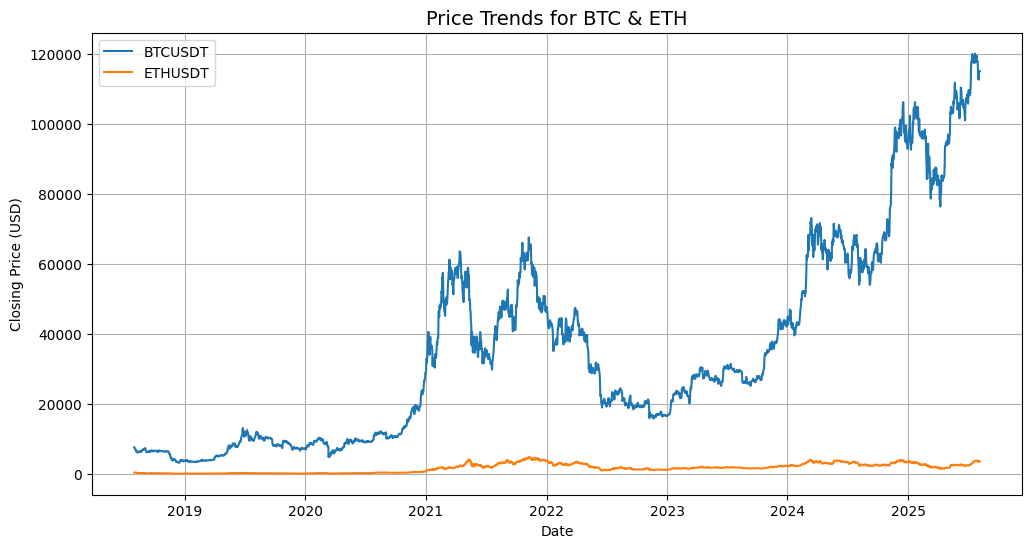

In [14]:
#  Price trends for major coins
import matplotlib.pyplot as plt
import seaborn as sns
top_coins = ['BTCUSDT', 'ETHUSDT']
plt.figure(figsize=(12,6))
for coin in top_coins:
    subset = df[df['symbol'] == coin]
    plt.plot(subset['date'], subset['close'], label=coin)
plt.title("Price Trends for BTC & ETH", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


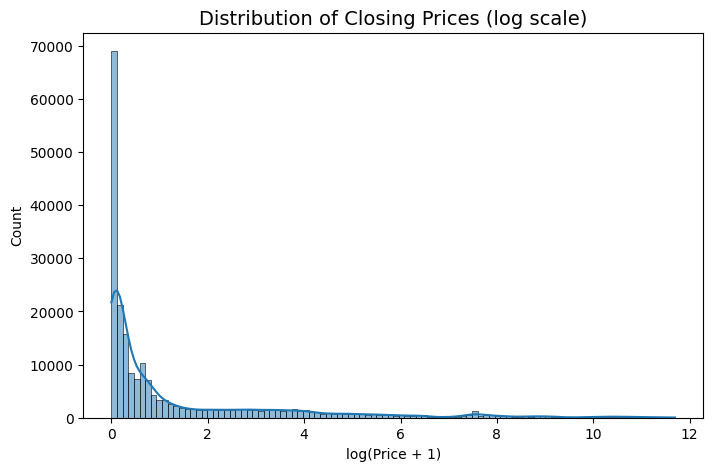

In [15]:
#  Distribution of closing prices (log scale to handle huge range)
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(df['close']), bins=100, kde=True)
plt.title("Distribution of Closing Prices (log scale)", fontsize=14)
plt.xlabel("log(Price + 1)")
plt.show()

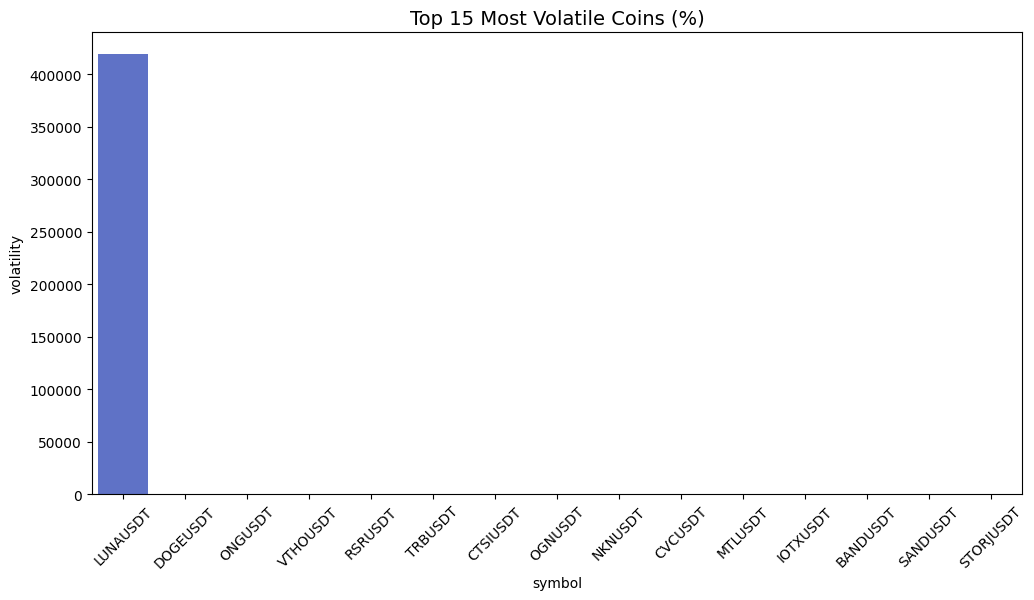

In [16]:
#  Volatility comparison (std dev of daily returns) by coin
vol_df = df.groupby('symbol')['close'].apply(lambda x: np.std(x.pct_change()) * 100).reset_index()
vol_df.columns = ['symbol', 'volatility']
plt.figure(figsize=(12,6))
sns.barplot(data=vol_df.sort_values('volatility', ascending=False).head(15),
            x='symbol', y='volatility', palette='coolwarm')
plt.title("Top 15 Most Volatile Coins (%)", fontsize=14)
plt.xticks(rotation=45)
plt.show()

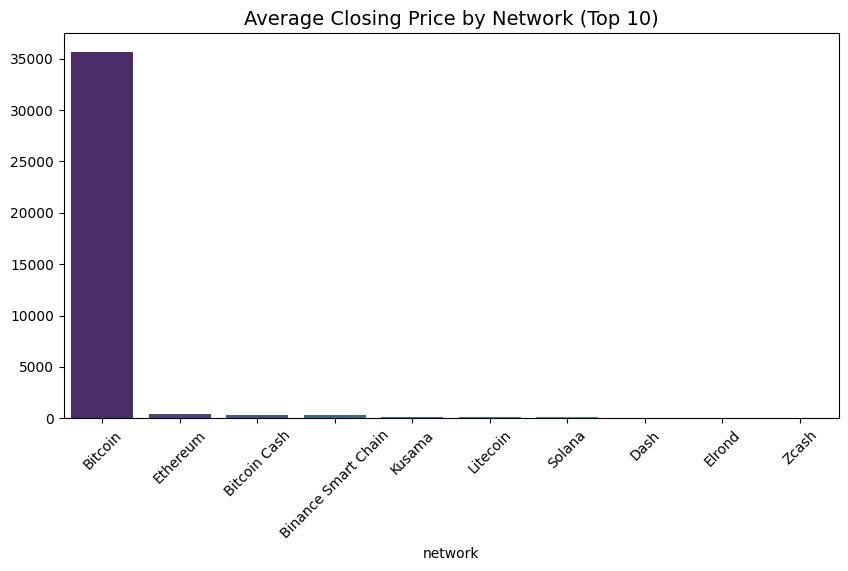

In [17]:
#  Average closing price by network (top 10 networks)
network_prices = df.groupby('network')['close'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=network_prices.index, y=network_prices.values, palette='viridis')
plt.title("Average Closing Price by Network (Top 10)", fontsize=14)
plt.xticks(rotation=45)
plt.show()